In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
from keras.models import load_model
K.set_image_data_format('channels_first')

import pickle
import cv2
import os.path
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
# from utility import *
# from webcam_utility import *

Using TensorFlow backend.


In [39]:
import matplotlib.pyplot as plt

In [9]:


# triplet loss function
#  y_pred - list containing three objects:
#         anchor(None, 128) -- encodings for the anchor images
#         positive(None, 128) -- encodings for the positive images
#         negative(None, 128) -- encodings for the negative images
def triplet_loss(y_true, y_pred, alpha = 0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # triplet formula components
    pos_dist = tf.reduce_sum( tf.square(tf.subtract(y_pred[0], y_pred[1])) )
    neg_dist = tf.reduce_sum( tf.square(tf.subtract(y_pred[0], y_pred[2])) )
    basic_loss = pos_dist - neg_dist + alpha
    
    loss = tf.maximum(basic_loss, 0.0)
   
    return loss



In [10]:
FRmodel = load_model('./model.h5', custom_objects={'triplet_loss': triplet_loss})

In [11]:
FRmodel.summary()

Model: "FaceRecoModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 96, 96)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 48, 48)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 64, 48, 48)   256         conv1[0][0]                      
______________________________________________________________________________________

In [6]:
def ini_user_database():
    # check for existing database
    if os.path.exists('database/user_dict.pickle'):
        with open('database/user_dict.pickle', 'rb') as handle:
            user_db = pickle.load(handle)   
    else:
        # make a new one
        # we use a dict for keeping track of mapping of each person with his/her face encoding
        user_db = {}
        # create the directory for saving the db pickle file
        os.makedirs('database')
        with open('database/user_dict.pickle', 'wb') as handle:
            pickle.dump(user_db, handle, protocol=pickle.HIGHEST_PROTOCOL)   
    return user_db


In [84]:
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

import imutils
from imutils import face_utils

def get_face(image):
    

  rects = detector(image,1)
  if len(rects) == 1:
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for face region , then
        # convert the facial landmark(x,y) coordinates to np array
        shape = predictor(image, rect)
        shape = face_utils.shape_to_np(shape)
        
        # convert dlib's rectangle to openCV style bounding box 
        # i.e (x,y,w,h) then draw face bounding box
        (x,y,w,h) = face_utils.rect_to_bb(rect)
        if x>1 and y>1:
          face = image[y-15:y+h+15,x-15:x+w+15]
          face = cv2.resize(face,(int(96),int(96)))
          face = np.asarray(face)
          plt.imshow(face)
          face = face.reshape(1,3,96,96)
          # print(x,y,w,h)
      # image = cv2.resize(image,(int(128),int(128)))
          # print(type(face))
          return face
  else:
    return ''  

In [85]:
def img_to_encoding(X,network):
    img = cv2.imread(X)
    img = get_face(img)
#     img = cv2.resize(img, (int(96),int(96)))
#     img =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
#     img = cv2.resize(image, (int(96),int(96)))

#     img = img.reshape(1,3,96,96)
    m = img.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(img)
    return embeddings

In [86]:
user_db = {}

def add_user_img_path(user_db, FRmodel, name, img_path):
    if name not in user_db: 
        user_db[name] = img_to_encoding(img_path, FRmodel)
        # save the database
        with open('database/user_dict.pickle', 'wb') as handle:
                pickle.dump(user_db, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('User ' + name + ' added successfully')
    else:
        print('The name is already registered! Try a different name.........')

In [87]:
def delete_user(user_db, name):
    popped = user_db.pop(name, None)
    
    if popped is not None:
        print('User ' + name + ' deleted successfully')
        # save the database
        with open('database/user_dict.pickle', 'wb') as handle:
                pickle.dump(user_db, handle, protocol=pickle.HIGHEST_PROTOCOL)
    elif popped == None:
        print('No such user !!')

### Testing

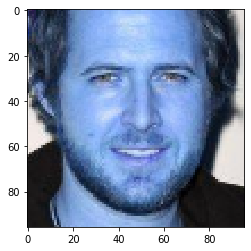

In [102]:
image = "./siamese dataset/A.J._Buckley/0.jpg"
user_db['buckley'] = img_to_encoding(image,FRmodel)

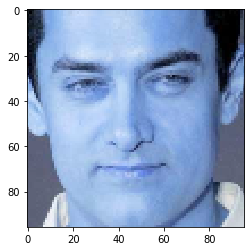

In [130]:
image = "./siamese dataset/Aamir_Khan/2.jpg"
user_db['amir'] = img_to_encoding(image,FRmodel)

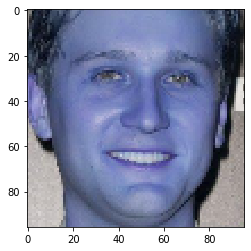

In [104]:
image = "./siamese dataset/Aaron_Staton/0.jpg"
user_db['aron'] = img_to_encoding(image,FRmodel)

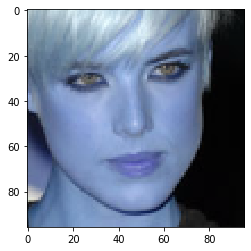

In [105]:
image = "./siamese dataset/Agyness_Deyn/2.jpg"
user_db['Deyn'] = img_to_encoding(image,FRmodel)

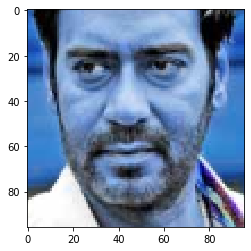

In [139]:
image = "./siamese dataset/Ajay_Devgn/20.jpg"
user_db['devgn'] = img_to_encoding(image,FRmodel)

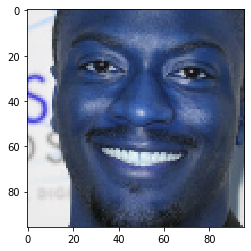

In [120]:
image = "./siamese dataset/Aldis_Hodge/21.jpg"
user_db['Hodge'] = img_to_encoding(image,FRmodel)

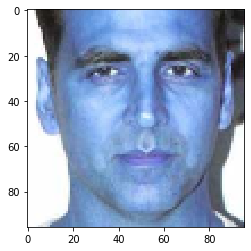

In [143]:
image = "./siamese dataset/Akshay_Kumar/18.jpg"
user_db['Kumar'] = img_to_encoding(image,FRmodel)

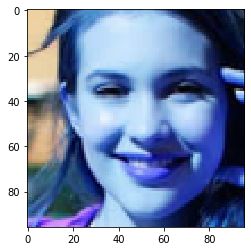

In [152]:
image = "./siamese dataset/Alexia_Fast/57.jpg"
user_db['Fast'] = img_to_encoding(image,FRmodel)

In [124]:
def find_face(image_path, database, model, threshold = 0.6):
    # find the face encodings for the input image
    encoding = img_to_encoding(image_path, model)
    
    min_dist = 99999
    # loop over all the recorded encodings in database 
    for name in database:
        # find the similarity between the input encodings and claimed person's encodings using L2 norm
        dist = np.linalg.norm(np.subtract(database[name], encoding) )
        print("name : ", name)
        print("distance ", dist)
        # check if minimum distance or not
        if dist < min_dist:
            min_dist = dist
            identity = name

    if min_dist > threshold:
        print("User not in the database.")
        identity = 'Unknown Person'
    else:
        print ("Hi! " + str(identity) + ", L2 distance: " + str(min_dist))
        
    return min_dist, identity

In [125]:
def do_face_recognition_from_image(user_db, FRmodel, threshold = 0.7, img_loc = "saved_image/1.jpg"):
    # resize the image
    img = cv2.imread(img_loc, 1)
    img = cv2.resize(img, (96, 96))
    # save the temporary image
    cv2.imwrite("saved_image/1.jpg", img)

    find_face(img_loc, user_db, FRmodel, threshold)

name :  buckley
distance  0.23619968
name :  amir
distance  0.24560657
name :  aron
distance  0.25263146
name :  Deyn
distance  0.38743916
name :  devgn
distance  0.13013853
name :  Hodge
distance  0.25504795
Hi! devgn, L2 distance: 0.13013853


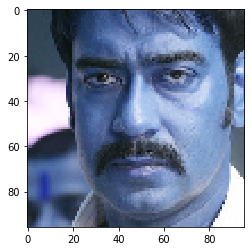

In [140]:
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.6, img_loc = "./siamese dataset/Ajay_Devgn/2.jpg")

name :  buckley
distance  0.1917465
name :  amir
distance  0.1631609
name :  aron
distance  0.1886172
name :  Deyn
distance  0.1477096
name :  devgn
distance  0.32323802
name :  Hodge
distance  0.23469837
Hi! Deyn, L2 distance: 0.1477096


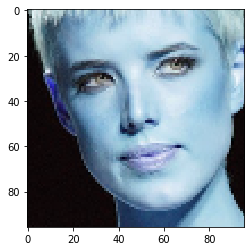

In [141]:
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.6, img_loc = "./siamese dataset/Agyness_Deyn/19.jpg")

name :  buckley
distance  0.16665359
name :  amir
distance  0.2092139
name :  aron
distance  0.21637273
name :  Deyn
distance  0.21423125
name :  devgn
distance  0.25336975
name :  Hodge
distance  0.15394038
Hi! Hodge, L2 distance: 0.15394038


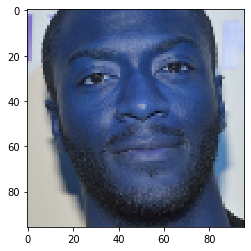

In [142]:
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.6, img_loc = "./siamese dataset/Aldis_Hodge/28.jpg")

name :  buckley
distance  0.22423005
name :  amir
distance  0.15878907
name :  aron
distance  0.14503576
name :  Deyn
distance  0.3206719
name :  devgn
distance  0.2789744
name :  Hodge
distance  0.3053362
name :  Kumar
distance  0.13854413
Hi! Kumar, L2 distance: 0.13854413


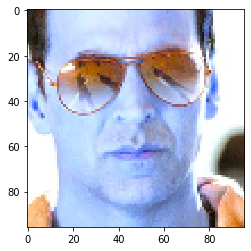

In [145]:
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.6, img_loc = "./siamese dataset/Akshay_Kumar/44.jpg")

name :  buckley
distance  0.16229147
name :  amir
distance  0.15777545
name :  aron
distance  0.18239021
name :  Deyn
distance  0.18979432
name :  devgn
distance  0.24483034
name :  Hodge
distance  0.12897882
name :  Kumar
distance  0.24215019
name :  Fast
distance  0.12693635
Hi! Fast, L2 distance: 0.12693635


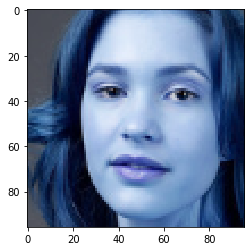

In [155]:
do_face_recognition_from_image(user_db, FRmodel, threshold = 0.6, img_loc = "./siamese dataset/Alexia_Fast/17.jpg")